In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
#from xgboost import plot_importance
#from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from utils.utils import remove_blacklisted, remove_redundant_columns, filter_device_groups
import joblib
from collections import defaultdict
import json
import tqdm
from utils.utils import smooth_seven_minute_intervals

SHIFT = -4
SMOOTH = 15

# hc = 'HC212B'
# prefix = f'tr_20230127213409_{hc}_'
#y_name = f'LMAM_HC212B_PL-------_TPS'
#groups = ["1", "4", "5"]

hc = 'HC201A'
#y_name = f'LMAM_{hc}_PLKL90---_TPG'
y_name = f'LMAM_{hc}_PL-------_TPS'


groups = ["1", "2", "3"]

cols = [
    "LMAM_PM201B_---------_TNI_ERPM", # v
    "LMAM_HC201B_NDDT01---_TDI", # s
    "LMAM_HC201B_NDPT01---_TPI", # p
    ]


#df = pd.read_csv(f'dumbdata/{prefix}{y_name}.csv')
df = pd.read_csv(f'maybe.csv')

df = remove_blacklisted(df, file='feature_lists/blacklist15.txt')
df = remove_redundant_columns(df)
df = filter_device_groups(df, file='feature_lists/15groups.json', groups=groups, y_name=y_name)

print(cols[2] in df.columns)

df = smooth_seven_minute_intervals(df=df, columns_to_smooth=df.columns.to_list(), minutes=SMOOTH)

# with open('whitelist15_final.json', 'r') as f:
#      to_take = json.load(f)

# df = df[to_take + [y_name]]

with open('feature_lists/15cleaned_features.json', 'r') as f:
    to_take = json.load(f)

df = df[list(set(to_take) | set(cols) | set([y_name]))]


df[y_name] = df[y_name].shift(SHIFT)
df = df[df[y_name].notnull() & df[y_name] != 0]


X = df.drop(columns=y_name).iloc[200:9000]

print(X.columns.to_list())
#X['vs'] = X[cols[0]] * X[cols[1]]
# X['ac'] = X[cols[0]] * X[cols[2]]
# X['bc'] = X[cols[1]] * X[cols[2]]
#X['vs_p'] = np.sqrt(X['vs'] / X[cols[2]])

# #STANDARD SCALLING

X = (X - X.mean(axis=0)) / X.std(axis=0)


y = df[y_name].iloc[200:9000]

X_train = X
y_train = y

# KFOLD validation
k_splits = 10

fold_metrics = defaultdict(lambda: [])

y_pred_history = list()


for k in tqdm.tqdm(range(k_splits), desc='Training k-fold'):
    n = len(X_train)

    _from = k * n // k_splits
    _to = (k + 1) * n // k_splits

    fold_X_train = pd.concat([X_train.iloc[0:_from+1], X_train.iloc[_to:]])
    fold_y_train = pd.concat([y_train.iloc[0:_from+1], y_train.iloc[_to:]])

    fold_X_test = X_train.iloc[_from:_to]
    fold_y_test = y_train.iloc[_from:_to]

    model_name = 'linear'
    #model = RandomForestRegressor(n_jobs=3, n_estimators=50, max_depth=10)

    params={ 
        'objective':'reg:squarederror',
        'max_depth': 5, 
        'n_estimators': 20,
        'colsample_bylevel': 0.4,
        'colsample_bytree': 0.7,
        'learning_rate': 0.2,
        'subsample': 0.8,
        'alpha': 0.0,
        'lambda': 1.0,
        'gamma': 0.5,
        'random_state':20
         }
    
    #model = XGBRegressor(**params)
    model = Lasso(positive=False, fit_intercept=True)
    model.fit(fold_X_train, fold_y_train)

    print(np.round(model.coef_, 2))

    y_pred = model.predict(fold_X_test)

    fold_mae = metrics.mean_absolute_error(fold_y_test, y_pred)
    fold_mse = metrics.mean_squared_error(fold_y_test, y_pred)
    #fold_mape = metrics.mean_absolute_percentage_error(fold_y_test, y_pred)
    fold_r2 = metrics.r2_score(fold_y_test, y_pred)

    fold_metrics['mae'].append(round(fold_mae, 3))
    #fold_metrics['mape'].append(fold_mape)
    fold_metrics['mse'].append(round(fold_mse, 3))
    fold_metrics['r2'].append(round(fold_r2, 3))

    y_pred_history.append(y_pred)
    

y_pred_history = np.concatenate(y_pred_history)

print('K-FOLD scores;')
for key, value in fold_metrics.items():
    print(f'{key}: {value};')

print(f"Mean mae {np.mean(fold_metrics['mae']):.2f};")
#print(f"Mean mape {np.mean(fold_metrics['mape']):.2f}")
print(f"Mean mse {np.mean(fold_metrics['mse']):.2f};")
print(f"Mean r2 {np.mean(fold_metrics['r2']):.2f};")

True
['LMAM_MP211-_---------_EPX', 'LMAM_MP211-_WLEQ01---_TDI', 'LMAM_HC201B_WPFT01---_TFI', 'LMAM_K211--_WPXRFI1--_PV', 'LMAM_RZM201_WPXRFI1--_PV', 'LMAM_PM201B_---------_TNI_ERPM', 'LMAM_MP211-_WPXRFI2--_PV', 'LMAM_TM141-_RDFQ01---_TFI', 'LMAM_OBM1C2_WPPT01---_TPI', 'LMAM_TM212-_---------_EPX', 'LMAM_TM211-_---------_EPX', 'LMAM_MF201-_NDXSLI8--_PV', 'LMAM_RZM211_WPXRFI1--_PV', 'LMAM_HC201B_NDPT01---_TPI', 'LMAM_HC201B_NDDT01---_TDI', 'LMAM_RZM201_WPFT01---_TFI', 'LMAM_TM213-_---------_EPX']


Training k-fold: 100%|██████████| 10/10 [00:00<00:00, 106.96it/s]

[-0.    0.   -0.   -0.   -1.25  3.27  0.    0.   -0.    0.    0.   -0.
  0.    3.31  9.13 -0.    1.47]
[ 0.    0.   -0.    0.   -0.23  3.94 -0.    0.   -0.35  0.    0.58 -0.
  0.    2.82  9.47 -0.    1.41]
[-0.    0.   -0.    0.   -0.76  3.57 -0.    0.   -0.    0.    0.   -0.
  0.    2.88  9.7  -0.    4.12]
[-0.    0.   -0.    0.   -0.68  3.07 -0.    0.   -0.    0.    0.48 -0.
  0.    3.47  9.52 -0.    2.92]
[-0.    0.   -0.    0.   -0.63  0.   -0.    0.   -0.    0.    0.26 -0.
  0.    6.82  9.16 -0.    2.7 ]
[-0.    0.   -0.   -0.   -0.07  2.73 -0.    0.   -0.    0.    0.08 -0.
  0.    4.27  9.37 -0.    2.65]
[-0.    0.   -0.   -0.   -0.08  2.94 -0.    0.   -0.    0.    0.23 -0.
  0.    3.67  9.26 -0.    2.53]
[-0.    0.   -0.   -0.   -0.18  2.96 -0.    0.   -0.    0.    0.36 -0.
  0.    3.99  9.46 -0.    3.2 ]
[-0.    0.   -0.    0.   -0.36  2.87 -0.    0.   -0.    0.    0.41 -0.
  0.    3.38  8.63 -0.    2.93]
[-0.    0.   -0.    0.   -0.15  0.84  0.    0.   -0.    0.    0.35 -0.
  

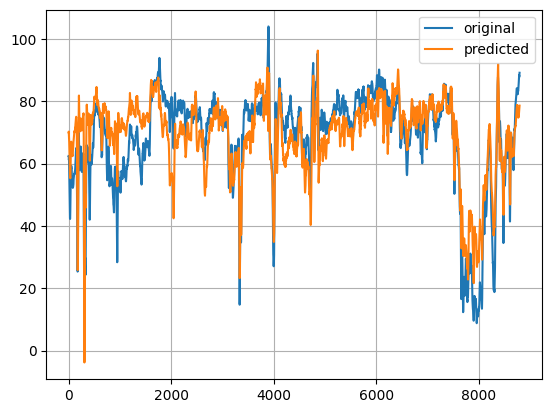

In [106]:
x_range = range(len(y_pred_history))
plt.plot(x_range, y_train, label='original')
plt.plot(x_range, y_pred_history, label='predicted')
plt.grid()
plt.legend()

In [11]:
# plot_df = df.copy().iloc[2700:3600]
# for col in df.columns:
#     fig = plt.figure(figsize=(8,6))
#     plt.plot(range(len(plot_df)), plot_df[col], label=col)
#     plt.legend()

In [12]:
# HYPERPARAMETERS OPTIMIZATION

# from sklearn.model_selection import RandomizedSearchCV

# params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [50, 100, 500, 1000],
#             'lambda': [1.0, 0.8, 0.6],
#             'gamma': [1.0, 0.5, 0.1]
#         }

# reg = XGBRegressor(seed=20)
# clf = RandomizedSearchCV(
#     estimator=reg,
#     param_distributions=params,
#     n_iter=25,
#     scoring='r2',
#     verbose=1
# )

# clf.fit(X_train, y_train)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [ ]:
# # force scores to be positive
# #scores = np.absolute(scores)
# print('-'*20)
# print('Scores')
# print(f'Mean MAE: {scores_mae.mean():.2f} +- {scores_mae.std():.2f}')
# print(f'Mean MSE: {scores_mse.mean():.2f} +- {scores_mse.std():.2f}')
# print(f'Mean R2: {scores_r2.mean():.2f} +- {scores_r2.std():.2f}')
# print('-'*20)
# print('Stats for Y')
# print(f'Min {y.min():.2f}')
# print(f'Max {y.max():.2f}')
# print(f'Mean {y.mean():.2f}')
# print(f'Std {y.std():.2f}')

# if model == 'xgb':
#     # plot feature importance
#     fig, ax = plt.subplots(ncols=3, figsize=(16,8))
#     plot_importance(model, max_num_features=20, ax=ax[0], title='weight', importance_type='weight')
#     plot_importance(model, max_num_features=20, ax=ax[1], title='gain', importance_type='gain')
#     plot_importance(model, max_num_features=20, ax=ax[2], title='cover', importance_type='cover')
#     plt.suptitle('XGBOOST internal feature importance')
#     plt.tight_layout()
#     plt.show()

# fig = plt.figure()

# error = y_test - test_pred
# plt.hist(error, bins=20)
# plt.title('Errors')
# plt.show()

# fig = plt.figure()

# test_n = len(test_pred)
# plt.plot(range(test_n), y_test, label='True')
# plt.plot(range(test_n), test_pred, label='Predicted')
# plt.legend()
# plt.show()

# fig = plt.figure()
# # Plot
# plt.hist(y, bins=20)
# plt.title(f'Y value for {y_name}')
# plt.xlabel('jednostka?')
# plt.tight_layout()
# plt.show()